## Initialization

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

ModuleNotFoundError: No module named 'keras_tuner'

# Data Preparation

## Load Data

In [5]:
# Load Data
df_original = pd.read_csv('Resale Flat Price.csv')
df_original

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
192789,2024-10,YISHUN,EXECUTIVE,358,YISHUN RING RD,01 TO 03,145.0,Maisonette,1988,62 years 09 months,888888.0
192790,2024-10,YISHUN,EXECUTIVE,352,YISHUN RING RD,01 TO 03,146.0,Maisonette,1988,62 years 10 months,848000.0
192791,2024-10,YISHUN,EXECUTIVE,277,YISHUN ST 22,10 TO 12,152.0,Maisonette,1985,59 years 11 months,867000.0
192792,2024-10,YISHUN,EXECUTIVE,293,YISHUN ST 22,01 TO 03,169.0,Apartment,1992,66 years 09 months,860000.0


## Data Exploration

In [6]:
df_original.info() # Quick summary of the data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192794 entries, 0 to 192793
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                192794 non-null  object 
 1   town                 192794 non-null  object 
 2   flat_type            192794 non-null  object 
 3   block                192794 non-null  object 
 4   street_name          192794 non-null  object 
 5   storey_range         192794 non-null  object 
 6   floor_area_sqm       192794 non-null  float64
 7   flat_model           192794 non-null  object 
 8   lease_commence_date  192794 non-null  int64  
 9   remaining_lease      192794 non-null  object 
 10  resale_price         192794 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 16.2+ MB


We can see that most of the data are object data which includes strings. We can see that there are many non-linearly related categorical variables such as street_name and town

In [7]:
df_original.describe() # Describe the numerical data

,floor_area_sqm,lease_commence_date,resale_price
count,192794.000000,192794.000000,1.927940e+05
mean,97.039779,1996.146768,5.053385e+05
std,24.039907,14.121343,1.763943e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.750000e+05
50%,93.000000,1996.000000,4.750000e+05
75%,112.000000,2011.000000,6.030000e+05
max,366.700000,2021.000000,1.588000e+06


In [8]:
#Describe categorical data

categorical_columns = ['town', 'flat_type', 'storey_range', 'flat_model']
for column in categorical_columns:
    unique_values = df_original[column].value_counts()
    print(f"Column: {column}")
    print(unique_values)
    print(f"Total categories: {len(unique_values)}\n")

Column: town
town
SENGKANG           15926
PUNGGOL            14331
WOODLANDS          13676
YISHUN             13153
TAMPINES           12909
JURONG WEST        12765
BEDOK              10176
HOUGANG             9717
CHOA CHU KANG       8808
ANG MO KIO          7944
BUKIT BATOK         7678
BUKIT MERAH         7379
BUKIT PANJANG       7013
TOA PAYOH           6013
KALLANG/WHAMPOA     5884
PASIR RIS           5651
SEMBAWANG           5334
QUEENSTOWN          5298
GEYLANG             4736
CLEMENTI            4310
JURONG EAST         3956
SERANGOON           3492
BISHAN              3449
CENTRAL AREA        1537
MARINE PARADE       1177
BUKIT TIMAH          482
Name: count, dtype: int64
Total categories: 26

Column: flat_type
flat_type
4 ROOM              81386
5 ROOM              47760
3 ROOM              45740
EXECUTIVE           14208
2 ROOM               3550
MULTI-GENERATION       79
1 ROOM                 71
Name: count, dtype: int64
Total categories: 7

Column: storey_range
storey

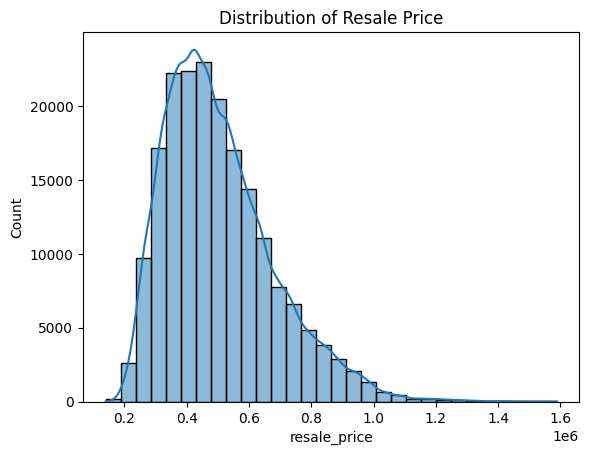

In [7]:
# Visualize the distribution of the resale price
sns.histplot(df_original['resale_price'], bins=30, kde=True)
plt.title('Distribution of Resale Price')
plt.show()

In [8]:
df_original.isnull().sum() # Check for null value

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

The data is relatively clean with no null values

In [9]:
# List all unique flat_type values
num_town = len(df_original['town'].unique().tolist())
num_street = len(df_original['street_name'].unique().tolist())

print(f"Number of towns: {num_town}, Number of streets: {num_street}")

Number of towns: 26, Number of streets: 569


There are too many streets for one-hot encoding, hence we choose to use 

## Data Cleaning & Feature Engineering

In [10]:
df = df_original.copy()

# Merge `block` and `street_name` into a new column `block_street`
df['block_street'] = df['block'] + ' ' + df['street_name']

# Extract the number of years from `remaining_lease`
df['remaining_years'] = df['remaining_lease'].apply(lambda x: int(x.split()[0])).astype(int)

# Split month and year
df = df.rename(columns={'month': 'year-month'})
df['year'] = df['year-month'].str[:4].astype(int)
df['month'] = df['year-month'].str[5:].astype(int)

# Extract convert storey_range to integer
# Function to extract the lowest floor number from the storey_range
def extract_lowest_floor(storey_range):
    return int(storey_range.split(' TO ')[0])

# Apply the function to the 'storey_range' column to create a new column with the lowest floor number
df['floor'] = df['storey_range'].apply(extract_lowest_floor)

# Convert flat type to specific numerical values based on general price ranking
# Define a mapping dictionary
flat_type_mapping = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'EXECUTIVE': 6,
    'MULTI-GENERATION': 7
}

# Map the 'flat_type' column to numerical values
df['flat_type'] = df['flat_type'].map(flat_type_mapping)

# Convert flat model to specific numerical values based on general price ranking
# Define the ranking mapping based on the given ranking
flat_model_mapping = {
    '2-room': 1,
    'Improved': 2,
    'Simplified': 3,
    'Standard': 4,
    'Apartment': 5,
    'Type S1': 6,
    'Type S2': 7,
    'Model A': 8,
    'Model A2': 9,
    'New Generation': 10,
    'Adjoined flat': 11,
    'Improved-Maisonette': 12,
    'Maisonette': 13,
    'Model A-Maisonette': 14,
    'Multi Generation': 15,
    'Premium Apartment': 16,
    'Premium Maisonette': 17,
    'DBSS': 18,
    'Terrace': 19,
    'Premium Apartment Loft': 20,
    '3Gen': 21
}

# Map the 'flat_model' column to numerical values based on ranking
df['flat_model'] = df['flat_model'].map(flat_model_mapping)

# Convert town and stree_name to categorical variables
df['town'] = df['town'].astype('category')
df['street_name'] = df['street_name'].astype('category')

# # Select features
df = df[['year', 'month', 'town', 'street_name', 'floor', 'flat_type', 'flat_model', 'floor_area_sqm', 'remaining_years', 'resale_price']]

print(df.dtypes)

df

year                  int32
month                 int32
town               category
street_name        category
floor                 int64
flat_type             int64
flat_model            int64
floor_area_sqm      float64
remaining_years       int32
resale_price        float64
dtype: object


,year,month,town,street_name,floor,flat_type,flat_model,floor_area_sqm,remaining_years,resale_price
0,2017,1,ANG MO KIO,ANG MO KIO AVE 10,10,2,2,44.0,61,232000.0
1,2017,1,ANG MO KIO,ANG MO KIO AVE 4,1,3,10,67.0,60,250000.0
2,2017,1,ANG MO KIO,ANG MO KIO AVE 5,1,3,10,67.0,62,262000.0
3,2017,1,ANG MO KIO,ANG MO KIO AVE 10,4,3,10,68.0,62,265000.0
4,2017,1,ANG MO KIO,ANG MO KIO AVE 5,1,3,10,67.0,62,265000.0
...,...,...,...,...,...,...,...,...,...,...
191138,2024,10,YISHUN,YISHUN CTRL,10,4,8,105.0,63,582000.0
191139,2024,10,YISHUN,YISHUN RING RD,7,4,8,92.0,86,593500.0
191140,2024,10,YISHUN,YISHUN RING RD,10,4,3,89.0,60,490000.0
191141,2024,10,YISHUN,YISHUN ST 43,10,4,8,93.0,94,620000.0


# Modelling

## Feature Engineering

In [11]:
# Encode categorical features for embedding
df['town_encoded'] = df['town'].astype('category').cat.codes
df['street_name_encoded'] = df['street_name'].astype('category').cat.codes

# Split features and target
X = df[['year', 'month', 'floor', 'floor_area_sqm', 'remaining_years', 'town_encoded', 'street_name_encoded', 'flat_type', 'flat_model']]
y = df['resale_price']

# Scale continuous features and ensure they're compatible with model input
scaler = StandardScaler()
X_scaled = X.copy()  # Avoid SettingWithCopyWarning by working on a copy
X_scaled[['year', 'month', 'floor', 'floor_area_sqm', 'remaining_years']] = scaler.fit_transform(
    X[['year', 'month', 'floor', 'floor_area_sqm', 'remaining_years']]
).astype('float32')  # Explicitly cast to float32

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Neural Network with Embedding Layers for `town` and `street_name`
# Define input layers for embeddings and scaled features
town_input = Input(shape=(1,), name='town_input')
street_name_input = Input(shape=(1,), name='street_name_input')
numeric_input = Input(shape=(7,), name='numeric_input')  # for scaled continuous features

# Embedding layers for categorical features
town_embedding = Embedding(input_dim=X['town_encoded'].nunique(), output_dim=5, name='town_embedding')(town_input)
town_embedding_flat = Flatten()(town_embedding)

street_name_embedding = Embedding(input_dim=X['street_name_encoded'].nunique(), output_dim=10, name='street_name_embedding')(street_name_input)
street_name_embedding_flat = Flatten()(street_name_embedding)

# Concatenate all inputs
combined = concatenate([town_embedding_flat, street_name_embedding_flat, numeric_input])

# Verify the shape of the concatenated layer
print("Shape after concatenation:", combined.shape)  # Expected to be (None, 20)

Shape after concatenation: (None, 22)


## Tuning

In [12]:
# from keras_tuner import Hyperband
# from tensorflow.keras import Model, Input
# from tensorflow.keras.layers import Dense, Concatenate
# from tensorflow.keras.callbacks import EarlyStopping

# def build_model(hp):
#     # Define inputs
#     town_input = Input(shape=(1,), name="town_input")
#     street_name_input = Input(shape=(1,), name="street_name_input")
#     numeric_input = Input(shape=(7,), name="numeric_input")

#     # Concatenate inputs
#     combined = Concatenate()([town_input, street_name_input, numeric_input])
    
#     # Define Dense layers with hyperparameter tuning for units
#     x = Dense(hp.Int('units_1', min_value=64, max_value=256, step=32), activation='relu')(combined)
#     x = Dense(hp.Int('units_2', min_value=32, max_value=128, step=16), activation='relu')(x)
#     x = Dense(hp.Int('units_3', min_value=16, max_value=64, step=16), activation='relu')(x)
#     x = Dense(hp.Int('units_4', min_value=8, max_value=32, step=8), activation='relu')(x)
#     output = Dense(1)(x)  # Regression output layer
    
#     # Create model
#     model = Model(inputs=[town_input, street_name_input, numeric_input], outputs=output)
    
#     # Compile model with tunable learning rate
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling='LOG')), 
#                   loss=tf.keras.losses.MeanSquaredError(), 
#                   metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
#     return model

# # Instantiate the tuner
# tuner = Hyperband(
#     build_model,
#     objective='val_loss',
#     max_epochs=100,
#     factor=3,
#     directory='Hyperparameters',
#     project_name='resale_price_prediction'
# )

# # Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Prepare inputs for training
# train_inputs = {
#     'town_input': X_train['town_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
#     'street_name_input': X_train['street_name_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
#     'numeric_input': X_train[['year', 'month', 'floor', 'floor_area_sqm', 'remaining_years', 'flat_type', 'flat_model']].values
# }

# val_inputs = {
#     'town_input': X_val['town_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
#     'street_name_input': X_val['street_name_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
#     'numeric_input': X_val[['year', 'month', 'floor', 'floor_area_sqm', 'remaining_years', 'flat_type', 'flat_model']].values
# }

# # Run the hyperparameter search
# tuner.search(
#     [train_inputs['town_input'], train_inputs['street_name_input'], train_inputs['numeric_input']], 
#     y_train,
#     validation_data=(
#         [val_inputs['town_input'], val_inputs['street_name_input'], val_inputs['numeric_input']], 
#         y_val
#     ),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stopping]
# )

# # Retrieve the best model
# best_model = tuner.get_best_models(num_models=1)[0]

# # Summary of best hyperparameters
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# print("Best hyperparameters:", best_hyperparameters.values)


Trial 254 Complete [00h 06m 43s]
val_loss: 3705689344.0

Best val_loss So Far: 1529529088.0
Total elapsed time: 03h 16m 12s
Best hyperparameters: {'units_1': 160, 'units_2': 128, 'units_3': 64, 'units_4': 16, 'learning_rate': 0.007514186698392906, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0204'}


c:\Users\e0564\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Model Training

In [22]:
# # Commented because tuner code is commented due to long runtime. 
# # Use mannual model building in subsequent runs with the best parameter derived from tunner

# # Retrieve the best hyperparameters
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Build a new model using the best hyperparameters
# model = build_model(best_hyperparameters)

# ----------

# Build best model normally based on the results from the tuner

# Add Dense layer
x = Dense(160, activation='relu')(combined)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(1)(x)  # Regression output layer

# Create and compile model
model = Model(inputs=[town_input, street_name_input, numeric_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007514186698392906), 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Prepare inputs for training
train_inputs = {
    'town_input': X_train['town_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
    'street_name_input': X_train['street_name_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
    'numeric_input': X_train[['year', 'month', 'floor', 'floor_area_sqm', 'remaining_years', 'flat_type', 'flat_model']].values
}

val_inputs = {
    'town_input': X_val['town_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
    'street_name_input': X_val['street_name_encoded'].values.reshape(-1, 1),  # Reshape to ensure correct input shape
    'numeric_input': X_val[['year', 'month', 'floor', 'floor_area_sqm', 'remaining_years', 'flat_type', 'flat_model']].values
}

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    [train_inputs['town_input'], train_inputs['street_name_input'], train_inputs['numeric_input']], 
    y_train,
    validation_data=(
        [val_inputs['town_input'], val_inputs['street_name_input'], val_inputs['numeric_input']], 
        y_val
    ),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/100


c:\Users\e0564\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['town_input', 'street_name_input', 'numeric_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


4745/4779 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 15501751296.0000 - mean_absolute_error: 60176.5977

c:\Users\e0564\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['town_input', 'street_name_input', 'numeric_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


4779/4779 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 15417666560.0000 - mean_absolute_error: 59994.6016 - val_loss: 1129036544.0000 - val_mean_absolute_error: 24814.7617
Epoch 2/100
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1173460480.0000 - mean_absolute_error: 25422.2734 - val_loss: 1084414976.0000 - val_mean_absolute_error: 24250.7051
Epoch 3/100
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1107663360.0000 - mean_absolute_error: 24615.9551 - val_loss: 933972480.0000 - val_mean_absolute_error: 22578.9746
Epoch 4/100
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 969219968.0000 - mean_absolute_error: 22961.6191 - val_loss: 921437760.0000 - val_mean_absolute_error: 22395.9629
Epoch 5/100
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 946763712.0000 - mean_absolute_error: 22598.0918 - val_loss: 878483008.0000 - val_mean_absolute_error: 21810.9609
Epoch 6/100
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 926045120.0000 - mean_absolute_error: 22314.6582 - val_los

## Model Evaluation

In [23]:
from sklearn.metrics import mean_absolute_error, r2_score

y_val_pred = model.predict([val_inputs['town_input'], val_inputs['street_name_input'], val_inputs['numeric_input']])

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_val, y_val_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate R^2 Score
r2 = r2_score(y_val, y_val_pred)
print("R^2 Score:", r2)

1195/1195 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step
Mean Absolute Error (MAE): 19877.352758409845
R^2 Score: 0.9752668820408797


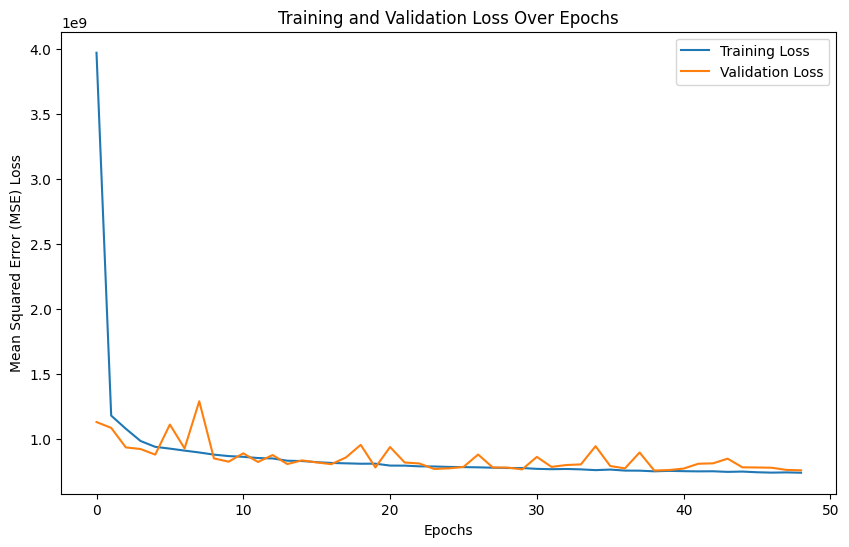

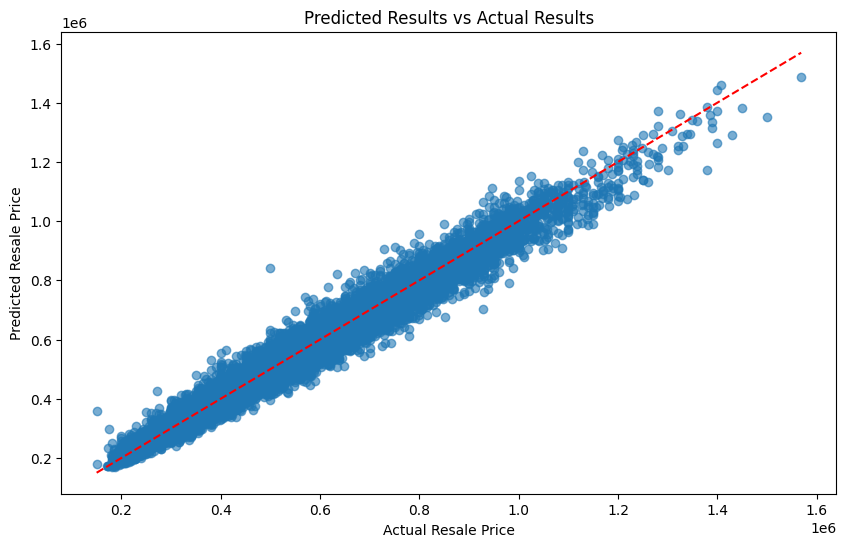

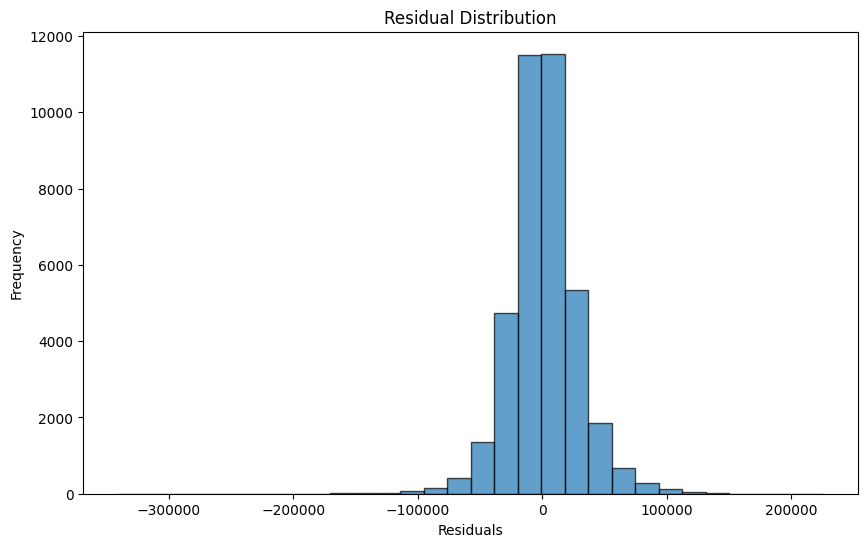

In [24]:
# 1. Plot Training and Validation Loss Over Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE) Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# 2. Plot Predicted Results vs Actual Results
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Line y=x for reference
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted Results vs Actual Results')
plt.show()

# 3. Plot Residual Distribution
# Calculate residuals on the validation set
residuals = y_val - y_val_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.show()

Learning Curve: Validation MAE starts to plateu around 20 epochs, however there are still spikes along the way and it truly stagnates around 70 epochs

Predicted vs Actual Resale Price: It shows a strong linear correlation with R-squared value of 0.973

Residual Curve: Most of the predictions lies within $100,000 from the actual resale price

## Export Model and Embedding

In [25]:
# -----------------------------
# Export Embeddings & Scaler
# -----------------------------

# After encoding categories during training
df['town_encoded'] = df['town'].astype('category').cat.codes
df['street_name_encoded'] = df['street_name'].astype('category').cat.codes

# Save the category mappings
town_categories = df['town'].astype('category').cat.categories.tolist()
street_name_categories = df['street_name'].astype('category').cat.categories.tolist()

# Save the mappings using joblib
joblib.dump(town_categories, 'town_categories.pkl')
joblib.dump(street_name_categories, 'street_name_categories.pkl')

# Save the scaler for future use
joblib.dump(scaler, 'NN_scaler.pkl')

# -----------------------------
# Export the Model
# -----------------------------

# # Save the entire model including architecture, weights, and optimizer state
model.save('NN_model.h5')
print("Model has been saved to 'NN_model.h5'")

Model has been saved to 'NN_model.h5'
